# Conductance-Based Spiking Neural Network (conductance-SNN)

The following code simulates a Coördinated Spiking Model with $\textit{N}$ neurons and a $\textit{d}$-dimensional input. The model contains the following functions:

- initialize_weights: initialize weights for the different neurons
- initialize_params_N: initialize the variables and parameters for simulating the network
- time_varying_signal: creates sinusoidal input signal with $\textit{d}$ dimensions
- run_N: runs the spiking network model
- plot_N: plots the results (input + input estimate, spike trains and voltages)

In addition, other functions have been added to plot the parameters of the network.

## Install required packages

Install required packages

In [269]:
import numpy as np
import pylab as pl
import math
from matplotlib import colors as mcolors
from mpl_toolkits.mplot3d import Axes3D
import random
import os
import matplotlib.animation as animation
import copy

## Functions used for simulation

### Initialize weights

Initialize weights

In [270]:
def initialize_weights(N, d):
    """ Initialize decoding weights of the different neurons. """
        
    if d == 2:
        # 2-dimensional input signal
        
        weights = np.linspace(0, 2 * np.pi, N + 1)       
        D = np.zeros((N,d))
        D[:, 0] = [np.sin(weight) for weight in weights[0:N]]
        D[:, 1] = [np.cos(weight) for weight in weights[0:N]]
        
    else:
        D = np.random.normal(0, 0.5, size=(N, d)) 
               
    return D

### Initialize parameters

Initialize parameters

In [271]:
def initialize_params_N(N, d, iterations, dt, D, beta):
    """ Initialize variables and parameters. """
    
    # timesteps
    t = np.arange(0, iterations) * dt

    # voltage
    voltage = np.zeros((N, iterations))

    # input estimate
    x_est = np.zeros((d, iterations))

    # spike train
    o = np.zeros((N, iterations))

    # threshold
    T = [(np.dot(weight, weight) + beta)/2 for weight in D]

    return (t, voltage, x_est, o, T)

### Time varying signal

Create time varying signal

In [272]:
def time_varying_signal():
    "Create time varying signal following a sinusoidal function. "
    
    c = []
    x = []
    
    # number of sinus periods (total # of sinus periods = 2 * cycles)
    cycles = 2
    t = np.linspace(0, np.pi, d + 1)       # starting points of d-dimensioan sinusoidal input signals
    
    for i in range(d):
        
        x_temp = np.sin(2 * np.linspace(-cycles * np.pi, cycles * np.pi, iterations) + t[i])
        dxdt = np.diff(x_temp)/dt
        c_temp = x_temp[:-1] + dxdt

        c.extend(c_temp)
        x.extend(x_temp)

    c = np.asarray(c).reshape((d, iterations - 1))
    x = np.asarray(x).reshape((d, iterations))

    return(c, x)

### Run simulation

In [273]:
def run_N(rho, E_e=1, E_i=-1, lambda_constant='C', var=0):
    """  """
    lambda_val = np.zeros(N)
    
    for t in range(1, iterations):

        # update input estimate
        dxestdt = (-1/tau) * x_est[:, t - 1] + np.dot(D.T, o[:, t - 1])
        x_est[:, t] = x_est[:, t - 1] + dt * dxestdt
        
        # compute lambda
        
        if lambda_constant == 'C':
            for i in range(N):
                lambda_val[i] = 1/np.dot(D[i], x[:, t] + x_est[:, t] + rho)
        elif lambda_constant == 'P':
            for i in range(N):
                lambda_val[i] = 1/np.dot(D[i], x[:, t - 1] + x_est[:, t - 1] + rho)
        elif lambda_constant == 'V':
            lambda_val = 1/var
                
        # update voltages
        dVdt = lambda_val * np.multiply(np.dot(D, c[:, t - 1]), E_e - voltage[:, t - 1]) \
                + lambda_val * np.multiply(np.dot(np.dot(D, D.T), o[:, t - 1]), E_i - voltage[:, t - 1])
        voltage[:, t] = voltage[:, t - 1] + dt * dVdt

        # check for neurons with voltages above threshold
        neurons = np.arange(0, N, 1)
        above_threshold = neurons[np.where(voltage[:, t] > T)]

        # reset neurons' voltages when threshold is exceeded
        if len(above_threshold) > 0:

            # select spiking neuron
            spike_neuron = np.random.choice(above_threshold)
            
            # update spikes
            o[spike_neuron, t] = 1/dt

### Visualize results

Functions used to visualize results

In [274]:
def zero_to_nan(values):
    """Replace every 0 with 'nan' and return a copy."""
    
    return [float('nan') if x==0 else x for x in values]

In [275]:
def plot_N(color, plot_voltage=1):
    """ Plots the results, including input and input estimate per dimension 
        as well as the spike trains and voltages of the individual neurons. """
    
    # determine number of plots
    if plot_voltage == 1:
        plot = d + N + 1
    else:
        plot = d + 1
    
    pl.subplots(plot, 1, figsize=(12, 16))
    pl.subplots_adjust(hspace=0.2 * N)
    counter = 1
    
    # enable LaTeX
    pl.rc('text', usetex=True)
       
    for i in range(1, d + 1):
        # input signal with more than 1 dimension
        pl.subplot(plot, 1, counter)
        pl.plot(x_est[i - 1,:], label=r'$\hat{x}_{%i}$' %i, color='gray')
        pl.plot(x[i - 1,:], label='$x_{%i}$' %i, color='k')
        pl.yticks([])
        pl.xticks([])
        pl.legend()
        counter = counter + 1
    
    # plot spike trains per neuron over time
    fig = pl.subplot(plot, 1, counter)
    
    for i in range(1, N + 1):
        values = zero_to_nan(o[i - 1, :] * i)
        pl.scatter(np.arange(0, iterations), values, color=color[i - 1][:]/255, label='N%i' %i, s=1.5)
    
    pl.title('Spike train', fontsize=15)
    pl.yticks([])
    pl.xticks([])
    pl.xlim(0, iterations)
    pl.legend()
    
    counter = counter + 1
    
    if plot_voltage == 1: 
        # plot voltage per neuron over time
        for i in range(1, N + 1):
            pl.subplot(plot, 1, counter)
            pl.plot(voltage[i - 1], color=color[i - 1][:]/255, label='voltage')
            pl.plot(np.arange(0, iterations), np.ones(iterations) * T[i - 1], color='gray', label='threshold')
            pl.xlim(0, iterations)
            pl.ylabel('Voltage')
            pl.title('Neuron %i' %i,  fontsize=15)
            pl.legend()
            counter = counter + 1
        
    pl.xlabel('time')

## Other functions

### Membrane voltage 

In [276]:
def visualize_voltage(rho):
    """ Compute and visualize membrane voltage of each neuron. """
    
    # compute voltage (by method 2)
    voltage2 = np.zeros((N, iterations))
    for t in range(iterations - 1):
        for i in range(N):
            voltage2[i, t] = np.dot(D[i], x[:, t] - x_est[:, t]) / np.dot(D[i], x[:, t] + x_est[:, t] + rho) 

    # plot voltages
    counter = 1
    pl.subplots(N, 2, figsize=(14, 4))
    # pl.suptitle('Voltage', fontsize=15)
    for i in range(1, N+1):
        pl.subplot(N, 2, counter)
        if counter == 1:
            pl.title(r'Online $\frac{dV_{i}}{dt} = D_{i}^{T}(\frac{x}{\tau} + \dot{x}) (1 - V_{i}) + \sum^{N}_{k = 1} (D_{i}^{T} D_{k} s_{k}) (-1 - V_{i})$',  fontsize=20)
        counter = counter + 1
        pl.plot(voltage[i - 1, :], color=color[i - 1][:]/255, label='N%i' %i)
        pl.ylabel('voltage')
        pl.xlabel('time')
        #pl.ylim(-2, 2)
        pl.subplot(N, 2, counter)
        if counter == 2:
            pl.title(r'Offline $V_{i} = \frac{D_{i}(x - \hat{x})}{D_{i}(x + \hat{x} + \rho)}$', fontsize=20)
        counter = counter + 1
        pl.plot(voltage2[i - 1, :], color=color[i - 1][:]/255, label='N%i' %i)
        pl.xlabel('time')
        #pl.ylim(-2, 2)
        pl.legend()

## Run simulation

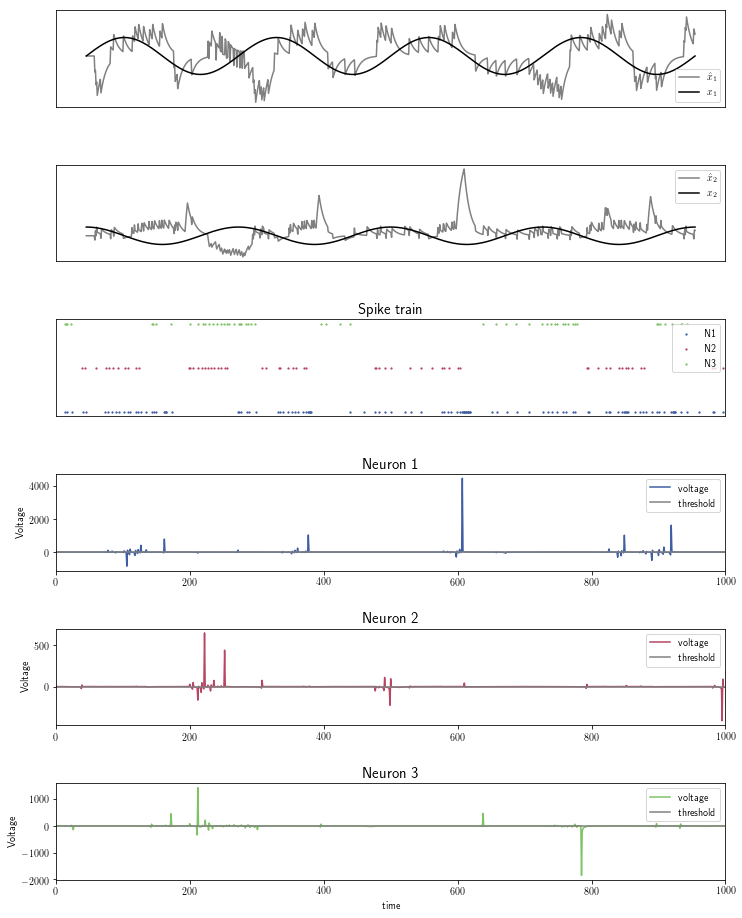

In [277]:
# Run simulation and plot results for given parameters
N = 3                                                    # number of neurons
d = 2                                                    # number of dimensions of signal input
iterations = 1000                                        # number of time steps
dt = 0.1                                                 # step size
# beta = 0.0                                               # cost 
color = np.random.randint(0, 255, size=(N, 3))           # color map for plotting the different neurons
rho = 0.1
lambda_constant = 'C'
var = 0.5
E_e = 1
E_i = -1

# run simulation
D = initialize_weights(N, d)                                                # initialize decoding weights
t, voltage, x_est, o, T = initialize_params_N(N, d, iterations, dt, D, beta)# initialize parameters
c, x = time_varying_signal()                                                # create d-dimensional input signal
run_N(rho, E_e, E_i, lambda_constant=lambda_constant, var=var)              # run spiking network
plot_N(color, plot_voltage=1)                                               # plot results

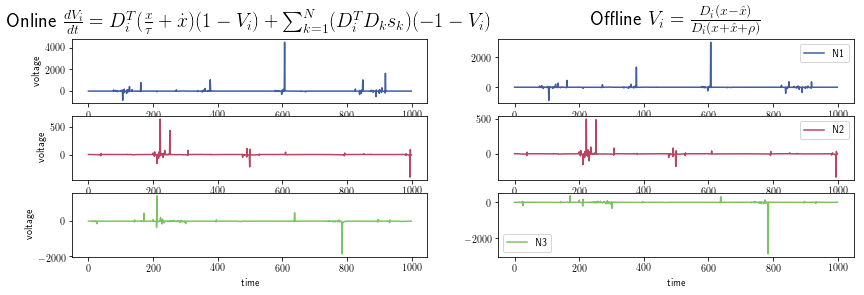

In [278]:
visualize_voltage(rho)